In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from IPython.display import Image
from qutip import *
from math import sqrt
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema, find_peaks

In [36]:
from qutip.ipynbtools import plot_animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation
from IPython.display import HTML

In [93]:
#
# System constants
#
# https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.105.173601?casa_token=ZeV560uY7gMAAAAA%3AFVbNRofeaxpIhNUnGl8zt3SMTmx20CgngNv3gdXy9uHARf2OrcENzKAsLoVHqnZ3zZm5WqjGmbITig 
# https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.105.100505?casa_token=kO3ld98M9VsAAAAA%3Ad3hMI-n-0txuQ-Jp8HbD3lEe0YXSHpdwX35XU49pUEHSoF6SBciFzyCnIcE-6M4ukZAiIh3WeET2lw
# Schuster Thesis
GHz = 10**9 #Hz
wc = 5.5 * GHz * 2 * np.pi # cavity frequency (5.5 GHz Schuster)
wa = wc + 0.8*GHz*2*np.pi # qubit frequency, wa + 0.35 GHz Schuster, 0.002 good for rabi
g = 0.017 * GHz * 2 * np.pi # coupling strength (orignally 0.017 GHz)
N = 20       # num cavity fock states
use_rwa = True       # rotating wave approx.? Only use when wa-wc small
n_th_a = 0  # number of thermal photons entering the cavity, 200 mK
n = 0  # starting fock state of the system


# the list of 'times' to evolve over
tlist = np.linspace(0, 50/GHz, 101) # tlist = np.linspace(0,25,101) pedagogical value

# cavity dissapation rate
# kappa = 0.0005  * GHz * 2 * np.pi 
kappa = 0.0#005  * GHz * 2 * np.pi 

# qubit dissapation rate
# gamma = 0.002 * 2 * np.pi * kappa # (g/(wa-wc))^2k 
gamma = 0.0#02 * 2 * np.pi * kappa

In [94]:
# Calculate expected Rabi Oscillation Frequency
# https://en.wikipedia.org/wiki/Vacuum_Rabi_oscillation
# https://www.rp-photonics.com/rabi_oscillations.html#:~:text=The%20angular%20frequency%20of%20the,amplitude%20divided%20by%20Planck's%20constant.

r = sqrt(4*(g**2)*(n + 1) + (wa-wc)**2)/GHz # rabi frequency in GHz
print(f"Expected Rabi Oscillation Frequency {r} GHz")
print(f"Expected Rabi Oscillation Period {1/r} ns")

#first intersection of the curves at resonance (wa=wc)
if wa == wc:
    t_max = np.pi/(r)
    print(f"The first intersection when wa=wc is at {t_max} ns")
            

Expected Rabi Oscillation Frequency 5.031085799063596 GHz
Expected Rabi Oscillation Period 0.198764250887179 ns


In [95]:
# for beats to be accurate, the frequencis must <= 1 kHz
# only use when there is detuning

# Calculate Carrier and Modulating Frequencies (If the wa-wc is the right size; there is an imaginary component)
fc = abs(wa/(2*np.pi)-wc/(2*np.pi))/(GHz)
fm = abs(wa/(2*np.pi)+wc/(2*np.pi))/(GHz)

print(f"Carrier frequency: {fc} GHz, Modulating Frequency: {fm} GHz")


Carrier frequency: 0.8 GHz, Modulating Frequency: 11.8 GHz


In [96]:
#
# Operators, Hamiltonion
#

# annhiliation and spin operator
a  = tensor(destroy(N), qeye(2))  # this stuff is default fock basis
sm = tensor(qeye(N), destroy(2))


#number of photons in cavity, and in qubit (operators)
nc = a.dag() * a
na = sm.dag() * sm 

#Hamiltonian: Jaynes-Cumming
if use_rwa:
    H = wc * nc + wa * na + g * (a.dag() * sm + a * sm.dag())
else:
    H = wc * nc + wa * na + g * (a.dag() + a) * (sm + sm.dag())
    

In [97]:
#
# Trying something with time evolution
#

# put qubit in excited state to start 
psi0 = tensor(basis(N,0), basis(2,1))

# create dissapation operators list (not sure why the list is needed)
collapse_ops = []

# assume cavity at 0K, cavity relaxation
rate = kappa
if rate > 0:
    collapse_ops.append(sqrt(rate)*a)

rate = kappa * n_th_a
if rate > 0:
    collapse_ops.append(sqrt(rate)*a.dag())
    
# qubit relaxation
rate = gamma
if rate > 0:
    collapse_ops.append(sqrt(rate) * sm)

# make the system evolve
output = mesolve(H, psi0, tlist, collapse_ops, [nc, na])

In [98]:
def time_for_val(times, output, outputs):
    """
    returns: the time at which a desired output occurs
    params: times - list of x values
        output - the output of interest to match x value to
        outputs - the total list of outputs
    """
    val_range = 0.01 # the range to consider values within to get result
    # first find the desired output in the outputs list
    out_idxL = np.where(abs(outputs-output) <= val_range)
    timesL = times[out_idxL]
    
    #trim so that it only includes time values that are notably different
    timesL = np.array(timesL)
    timesL = np.around(timesL, 9) # since we are in the GHz range we want the same order of accuracy
    timesL = np.unique(timesL)
    return timesL

In [111]:
def freq_guesser(data):
    if np.size(data) == 0:
        return 0
    else:
        peak_ind = find_peaks(data)[0]
        T = tlist[peak_ind[1]] - tlist[peak_ind[0]]
        freq=1/T
        return freq
n_a = output.expect[1]
freq = freq_guesser(n_a)
print(freq/GHz)

133.32


(0.0008684009735607234, 100000000, 0, 0.9991315990264393, 0)
[-3.89145273e-05  1.19100425e+08  1.53812439e-01  9.99126053e-01]
Rabi Frequency from fitting: 0.23820085001521707GHz


Text(0.5, 1.0, 'Vacuum Rabi oscillations')

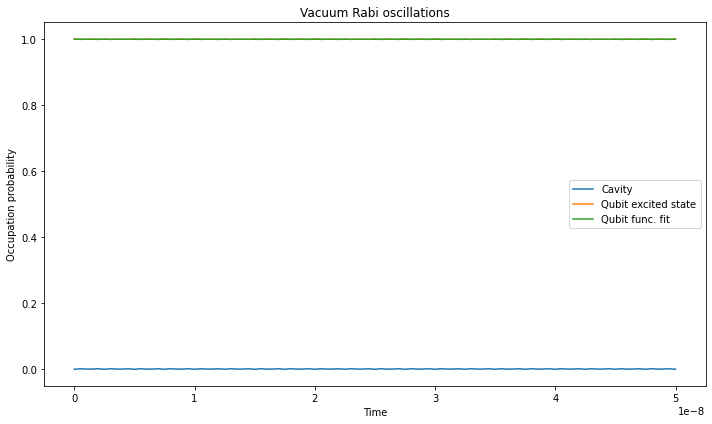

In [99]:
#
# Graph the time evolution
#

n_c = output.expect[0] # expectation value for the number of photons in the cavity 
n_a = output.expect[1] # expectation value for the number of photons in the qubit


# initial fitting guesses - for rabi frequency guessing 
def init_guesser(dataset, tlist):
    amp1 = (max(dataset) - min(dataset))/2
    freq1 = r#1/((time_for_val(tlist,0,dataset)[1] - time_for_val(tlist,0,dataset)[0])) #Hz
    shift1 = amp1 + min(dataset) 
    phase1 = 0#time_for_val(tlist,shift1,dataset)[0]
    l_max = argrelextrema(dataset, np.greater)[0] # get np.array in a tuple of the local maxima of the qubit
    #Tq1 = -tlist[l_max[0]]/np.log(dataset[l_max[0]])

    if kappa==0 and gamma ==0:
        damp1 = 0
    else:
        damp1 = -(np.log(dataset[l_max[0]]))/(tlist[l_max[0]])
    return amp1, 10**8, phase1, shift1, damp1


# The fit function
# Only use if you expect sinusoidal behavior

init_guess = init_guesser(n_a,tlist)
print(init_guess)
def get_fit(init_guess):
    if kappa==0 and gamma==0:
        def test(x, a, b,c, d):
            return a*(np.sin(b*x + c))**2 + d

        param, param_cov = curve_fit(test, tlist, n_a, maxfev=500000, p0=init_guess[:4])
        fit_func = param[0]*((np.sin(param[1]*tlist + param[2]))**2) + param[3]
    else:
        def test(x, a, b,c, d,e):
            return a*np.exp(-e*x)*(np.sin(b*x + c))**2 + d

        param, param_cov = curve_fit(test, tlist, n_a, maxfev=500000, p0=init_guess)
        fit_func = param[0]*np.exp(-param[4]*tlist)*((np.sin(param[1]*tlist + param[2]))**2) + param[3]
    return param, fit_func

param, fit_func = get_fit(init_guess)
print(param)
print(f"Rabi Frequency from fitting: {abs(2*param[1])/GHz}GHz")

fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist, n_c, label="Cavity")
axes.plot(tlist, n_a, label="Qubit excited state")
axes.plot(tlist, fit_func, label="Qubit func. fit")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Vacuum Rabi oscillations')



In [ ]:
#
# Cavity Wigner Function fun
#

# put qubit in excited state to start 
#psi0 = tensor(basis(N,0), basis(2,1))

output = mesolve(H, psi0, tlist, collapse_ops, [])

expect_nc_L = np.array([expect(nc, output.states[t]) for t in range(101)]) # get the expectation of the number of cavity photons

In [ ]:
output_gs_times = np.where(expect_nc_L <= 0.01)[0]
print(output_gs_times)
tlist[output_gs_times]

In [ ]:
# get density matrix list
dmL = np.array(output.states)[output_gs_times]


In [ ]:
xvec = np.linspace(-3,3,200)
fig, axes = plt.subplots(1,len(dmL), sharex=True, figsize=(3*len(dmL) + 5,3))
cm = plt.get_cmap('RdBu')
sm = plt.cm.ScalarMappable(cmap=cm, norm=mpl.colors.Normalize(-.25,.25))
plt.colorbar(sm)

tlist = np.around(tlist, 10)
for idx, dm in enumerate(dmL):
    # get reduced dm for cavity
    dm_cavity = ptrace(Qobj(dm), 0)
    
    # calculate its wigner function
    W = wigner(dm_cavity, xvec, xvec) # yes this is position and momentum - wigner_transform is more specific
    
    # plot its wigner function
    axes[idx].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=cm)
    axes[idx].set_xlabel("Position") # I think this is right ... not sure, here are the sources
    axes[idx].set_ylabel("Momentum")
    axes[idx].set_title(f"t = {tlist[output_gs_times][idx]*GHz}")

    
    # https://en.wikipedia.org/wiki/Optical_phase_space
    # http://mediatum.ub.tum.de/doc/1463517/1463517.pdf
    # https://uncw.edu/phy/documents/shafer499talk.pdf
    # https://dergipark.org.tr/en/download/article-file/130801

In [ ]:
#
# Animation of Wigner Fn
# 
plt.rcParams["figure.figsize"] = [12,6]
plt.rcParams["figure.autolayout"] = True

fps = 20
frn = 75

xvec = np.linspace(-5.,5.,100)
x,y = np.meshgrid(xvec, xvec)

dm_cavity = ptrace(Qobj(output.states[0]), 0) #states[n] initially
W = wigner(dm_cavity, xvec, xvec)    

def update_plot(frame_number):
    plot[0].remove()
    dm_cavity = ptrace(output.states[frame_number], 0)
    W = wigner(dm_cavity, xvec, xvec)
    plot[0] = ax.plot_surface(x,y,W, cmap = plt.get_cmap('RdBu'))
    return plot
    
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot = [ax.plot_surface(x, y, W, color='0.75',rstride=1, cstride=1)]


ax.set_xlim3d(-5, 5)
ax.set_ylim3d(-5, 5)
ax.set_zlim3d(-0.25, 0.25)

anim = animation.FuncAnimation(fig, update_plot, frn, interval=1000/fps, blit = False)
#plt.show()
HTML(anim.to_html5_video())




Visual of Detuning

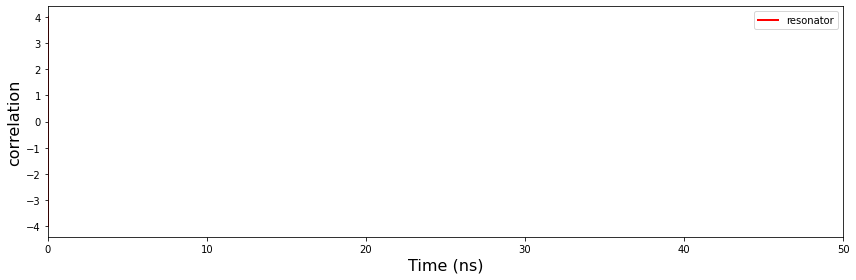

In [103]:
#
# Get correlation function of resonator
#

psi0 = tensor(coherent(N, sqrt(4)), (basis(2,0)+basis(2,1)).unit())
tlist = np.linspace(0, 25/GHz, 10000)
corr_vec = correlation_2op_2t(H, psi0, None, tlist, [], a.dag(), a, args={},options = Options(nsteps=10000))
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, np.real(corr_vec), 'r', linewidth=2, label="resonator")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
ax.set_xlim(0,50)
fig.tight_layout()

In [101]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

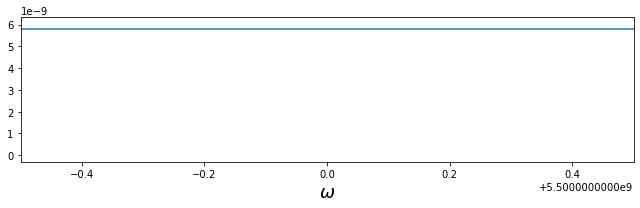

In [102]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(w / (2 * np.pi), abs(S))
ax.set_xlabel(r'$\omega$', fontsize=18)
ax.set_xlim(wc/(2*np.pi)-.5, wc/(2*np.pi)+.5);

Text(0.5, 1.0, 'Detuning Sweep')

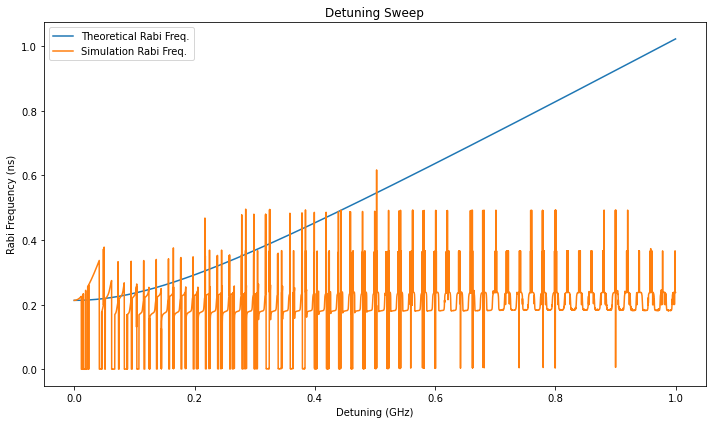

In [77]:
# make lists to store the theory and simulation frequencies
theoryL = []
simL = []
deltaL = np.linspace(0, 1, 10000) # detuning to iterate over

for delta in deltaL:
    # solve for rabi freqency (theory), add to list
    rabi_theory = sqrt(4*((g/GHz)**2)*(n + 1) + (delta)**2)
    theoryL += [rabi_theory]
    # set wa as a function of detuning
    wc = 5.5 * GHz * 2 * np.pi
    wa = wc + delta*GHz*2*np.pi
    H = wc * nc + wa * na + g * (a.dag() * sm + a * sm.dag())
    psi0 = tensor(basis(N,0), basis(2,1))
    # plug this into Hamiltonian/ evolve it over times in tlist
    result = mesolve(H, psi0, tlist, collapse_ops, [nc, na])
    n_a = result.expect[1]
    # fit to the output for the qubit (helper)
    init_guess = init_guesser(n_a,tlist)
    param, fit_func = get_fit(init_guess)
    # pull rabi frequency from the fit, add to list
    rabi_sim = abs(2*param[1])/GHz
    simL += [rabi_sim]

# graph the theory fit and the actual fit
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(deltaL, theoryL, label="Theoretical Rabi Freq.")
axes.plot(deltaL, simL, label="Simulation Rabi Freq.")
axes.legend(loc=0)
axes.set_xlabel('Detuning (GHz)')
axes.set_ylabel('Rabi Frequency (ns)')
axes.set_title('Detuning Sweep')